---
title: "Post 4 - Implementing Perceptron"
author: Col McDermott
date: "03-31-2025"
description: "An introductory exploration of the Perceptron algorithm."
format: html
code-fold: true
execute:
  warning: false
  message: false
---

# Abstract

The primary goal of this brief study on perceptron is to explore and investigate the processes under the hood of this algorithm $-$ one of the oldest machine learning algorithms to exist.  The functionality of and logic behind the perceptron algorithm is a backbone of many modern ML methods and models.  It is crucial to develop at least a basic understanding of how perceptron works and why its design is as such.  This introductory dive into the inner workings of perceptron involves examining the conditions in which the algorithm is successful, the conditions in which the algorithm must be manually adjusted to prevent non-convergence, various ways the algorithm can be refined to operate on more complex data, and the general limitations and implications associated with this algorithm.  Over several experiments involving multiple datasets with different key characteristics (such as linear separability and number involved variables), my implementation of the perceptron algorithm is analyzed.  With low-dimensional, linearly separable data, I found perceptron to perform with high accuracy (usually perfect) over a relatively small number of iterations.  However, with more complex and or not linearly separable data, the algorithm's performance decreased in accuracy and or runtime.  Yet, using an alternative version of perceptron allowed for the mitigation of some of the flaws exhibited by the original algorithm on certain datasets

For the implementation of the original and enhanced perceptron algorithms, visit [perceptron.py](https://github.com/Col-McDermott/Col-McDermott.github.io/blob/main/posts/post_4/perceptron.py) and [MBperceptron.py](https://github.com/Col-McDermott/Col-McDermott.github.io/blob/main/posts/post_4/MBperceptron.py).
 

## Generating Data

In [21]:
# Including all additional imports
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
import torch as tch

# Porting over perceptron and minibatch perceptron implementations
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
from MBperceptron import MBPerceptron, MBPerceptronOptimizer
tch.manual_seed(100) # For consistent data generation
plt.style.use('seaborn-v0_8-whitegrid') # For consistent plotting

# Generating the data - Some code provided by Prof. Chodrow
## Linearly separable 2D data
y1 = tch.arange(500) >= int(500 / 2)
X1 = y1[:, None] + tch.normal(0.0, 0.2, size = (500, 2))
X1 = tch.cat((X1, tch.ones((X1.shape[0], 1))), 1)

# Not linearly separable 2D data
y2 = tch.arange(500) >= int(500 / 2)
X2 = y2[:, None] + tch.normal(0.0, 0.4, size = (500, 2))
X2 = tch.cat((X2, tch.ones((X2.shape[0], 1))), 1)

# 6D data, low-noise
y3 = tch.arange(500) >= int(500 / 2)
X3 = y3[:, None] + tch.normal(0.0, 0.2, size = (500, 6))
X3 = tch.cat((X3, tch.ones((X3.shape[0], 1))), 1)

# 6D data, high-noise
y4 = tch.arange(500) >= int(500 / 2)
X4 = y4[:, None] + tch.normal(0.0, 0.5, size = (500, 6))
X4 = tch.cat((X4, tch.ones((X4.shape[0], 1))), 1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


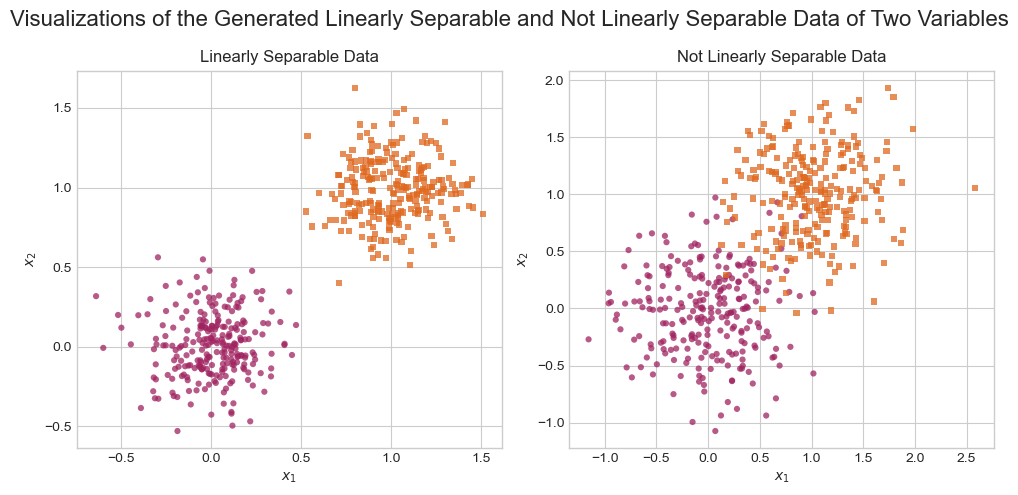

In [22]:
# Some code provided by Prof. Chodrow
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]

    # Custom color map
    colors = ["purple", "darkorange"]  
    cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "none", cmap = cmap, vmin = -2, vmax = 2, alpha = 0.75, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plot_perceptron_data(X1, y1, ax[0])
plot_perceptron_data(X2, y2, ax[1])
ax[0].set_title("Linearly Separable Data")
ax[1].set_title("Not Linearly Separable Data")
fig.suptitle("Visualizations of the Generated Linearly Separable and Not Linearly Separable Data of Two Variables", fontsize = 16)
plt.tight_layout()

*Code above generates four random data sets: 1. Linearly separable data with two features.  2. Not linearly separable data with two features.  3. & 4. Possibly linearly separable data with 6 features (some code provided by Prof. Chodrow).*

**Figure 1**

To test and investigate the perceptron algorithm, I have created four random datasets.  The first data set has two features and is intentionally linearly separable $-$ the perceptron algorithm should converge to a loss of 0 for this dataset.  The second data set also has two features but is intentionally *not* linearly separable $-$ the perceptron algorithm will not be able to converge to a loss of 0 for this data set and will need to be manually terminated after a certain number of iterations.  The third and fourth datasets have 6 features and are used to show how the perceptron works with data that can't be easily visualized $-$ the third dataset is linearly separable due to its low-noise factor while the fourth dataset is likely not linearly separable due to its high-noise factor.

## Implementing the Perceptron Algorithm

For this introductory study, I have implemented a rudimentary version of the perceptron algorithm.  This implementation involves three class definitions: `LinearModel`,   `Perceptron`, and `PerceptronOptimizer`.

**`LinearModel`**:

-   `self.w`: An instance variable to store the weights vector of a linear model.
-   `score(X)`: Method to compute the score $s_i$ using $\langle$**$w$**$, x_i\rangle$ for each data point in the feature matrix **$X$**.
-   `predict(X)`: Method to compute the classification prediction $\hat{y}_i$ $\in\{0, 1\}$ for each data point:
    -   $\hat{y_i} = 1$ if ($s_i > 0$) and $\hat{y_i} = 0$ otherwise.

**`Perceptron`** (inherits from **`LinearModel`**):

-   `loss(X, y)`: Method to compute the misclassification rate in the data by taking the average number of misclassification instances $-$ A point $x_i$ is classified correctly if $s_iy_i' > 0$, where $y_i' \in \{-1, 1\}$ is the modified classification label (computed with $2y_i - 1$).
-   `grad(x, y)`: Method to compute the perceptron update for a sampled data point.
    -   This method takes as arguments `x`: the row of the feature matrix **$X$** corresponding to the sampled data point $-$ and `y`: the classification target vector.
    -   This method first computes the score $s_i$ of the sampled data point with $\langle$**$w$**$, x_i\rangle$.
    -   This method then computes the vector $-\mathbf{1}[s_i(2y_i - 1) < 0](2y_i - 1)x_i$ which represents the perceptron update (moving the score $s_i$ closer to the target $y_i$) with respect to the sampled data point.  This vector, which represents the gradient of the loss function, is defined by three components:
        1. $\mathbf{1}[s_i(2y_i - 1) < 0]$ indicates whether or not the current data point $x_i$ is correctly classified.  If the point $x_i$ is correctly classified, the whole vector evaluates to $[\mathbf{0}]$, and thus no changes are made to the current weights vector, $\mathbf{w}$.  If the point $x_i$ is incorrectly classified, the vector evaluates to $-(2y_i - 1)x_i$ which will change $\mathbf{w}$.
        2. $(2y_i - 1)x_i$ represents the update to the score data point $x_i$ that occurs in the event of a misclassification (i.e. moving $s_i$ closer to the value of $y_i$).
        3. Lastly, the preceding "$-$" indicates that if the point $x_i$ is misclassified, the vector $\mathbf{w}$ needs to be updated in the **opposite** direction of the gradient of the loss function.
    -   Ultimately, this method computes an update to a sampled data point that later adjusts the weight vector of the perceptron algorithm to better fit the sampled data point.

## Evaluating the Perceptron Implementation

In [23]:
# Method to evaluate the perceptron algorithm - Some code provided by Prof. Chodrow
def perceptron_test(X, y, max_it, verbose):
    
    ## Instantiate a model and an optimizer
    p = Perceptron()
    opt = PerceptronOptimizer(p)

    # Initialize the loss
    loss = 1.0

    # Keeping track of loss values (length of this array is also the number of algorithm iterations)
    loss_vec = []

    n = X.size()[0]
    while (loss > 0):
        
        # Termination condition
        if (max_it != None) and (len(loss_vec) >= max_it):
            break

        # Tracking the evolution of the loss function
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # Selecting a random data point
        i = tch.randint(n, size = (1,))
        x_i = X[[i],:]
        y_i = y[i]
        
        # Performing perceptron update using the random data point
        opt.step(x_i, y_i)

    if (verbose):
        # Observe the algorithm's performance with the evolution of the loss function
        print("Evolution of loss values:\n")
        for i in range(5):
            print(f"Iteration: {i} | Loss: {loss_vec[i]}")
        print("...\n")
        print(f"Total Iterations: {len(loss_vec)} | Final Loss: {loss_vec[-1]}")

In [24]:
# Evaluating perceptron on 2D, linearly separable data
pe1 = perceptron_test(X1, y1, None, True)

Evolution of loss values:

Iteration: 0 | Loss: 0.5
Iteration: 1 | Loss: 0.1860000044107437
Iteration: 2 | Loss: 0.1860000044107437
Iteration: 3 | Loss: 0.1860000044107437
Iteration: 4 | Loss: 0.1860000044107437
...

Total Iterations: 1282 | Final Loss: 0.0


*Code above checks the implementation of the perceptron algorithm on a linearly separable dataset of two variables (some code provided by Prof. Chodrow).*

In the above code cell, the implementation of the perceptron algorithm is tested on the generated 2D, linearly separable data.  Considering that this data is linearly separable, the algorithm should be able to converge to a loss of $0$ with a finite number of iterations.  In the output above, the evolution of the loss value across the first five (or less if appropriate) iterations of the perceptron algorithm followed by the loss value at the algorithm's final iteration is displayed.  This output aligns with the expected behavior of the algorithm as the loss value is shown to decrease during the initial iterations and eventually converge to a value of $0$.

## Experimenting With Perceptron

In [25]:
# Plotting helper method provided by Prof. Chodrow
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = tch.linspace(x_min, x_max, 101)
    y = -1 * (((w_[0] * x) + w_[2])/w_[1])
    ax.plot(x, y, **kwargs)

# Function to plot the behavior of the perceptron algorithm
def perceptron_plotter(X, y, max_it, dim):
    
    # Code Provided by Prof. Chodrow
    ## Initialize a perceptron 
    p = Perceptron()
    opt = PerceptronOptimizer(p)
    p.loss(X, y)

    # Initialize for main loop
    loss = 1

    # Bookkeeping arrays
    loss_vec = []
    updated_losses = []
    old_w_vals = []
    new_w_vals = []
    sampled_points = []
    update_its = []

    n = X.size()[0]
    while loss > 0:
        
        # Terminating condition
        if (max_it != None) and (len(loss_vec) >= max_it):
            break

        loss = p.loss(X, y).item()
        loss_vec.append(loss)

        # Save the current value of w for plotting later
        curr_w = tch.clone(p.w)
        
        # Sample random data point
        i = tch.randint(n, size = (1,))
        x_i = X[[i],:]
        y_i = y[i]
        
        # Make an optimization step - Now p.w is the new weight vector
        step = opt.step(x_i, y_i)
        if step > 0:
            sampled_points.append(i)
            old_w_vals.append(curr_w)
            new_w_vals.append(tch.clone(p.w))
            updated_loss = p.loss(X, y).item()
            updated_losses.append(updated_loss)
            update_its.append((len(loss_vec)))

    filler = " Not " if (loss_vec[-1] > 0) else " "
    if (dim <= 2):
        # Plotting the algorithm procedure
        plt.rcParams["figure.figsize"] = (10, 7.5)
        current_ax = 0
        fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
        markers = ["o", ","]
        marker_map = {-1 : 0, 1 : 1}
        for i in range(5):
            ax = axarr.ravel()[current_ax]
            plot_perceptron_data(X, y, ax)
            draw_line(old_w_vals[i], x_min = -1, x_max = 2, ax = ax, color = "slategray", linestyle = "dashed")
            draw_line(new_w_vals[i], x_min = -1, x_max = 2, ax = ax, color = "slategray")
            ax.scatter(X[sampled_points[i],0],X[sampled_points[i],1], color = "slategray", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2 * (y1[sampled_points[i]].item()) - 1]])
            ax.set_title(f"Current Overall\nLoss = {updated_losses[i]:.3f}")
            ax.set(xlim = (-1, 2), ylim = (-1, 2))
            ax.text(-0.55, 1.55, f"Iteration: {update_its[i]}", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
            current_ax += 1
        ax = axarr.ravel()[-1]
        plot_perceptron_data(X, y, ax)
        draw_line(new_w_vals[-1], x_min = -1, x_max = 2, ax = ax, color = "slategray")
        ax.set_title(f"Final Overall\nLoss = {loss_vec[-1]:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        ax.text(-0.55, 1.55, f"Iteration: {len(loss_vec)}", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad=0.3"))
        fig.suptitle("Convergence of Loss Value and Separation Line for 2D" + filler + "Linearly Separable Data", fontsize = 16)
        fig.text(0.5, 0.005, "Sampled Points at the Current Iteration are Outlined in Black", ha = "center", va = "center", fontsize = 14)
        plt.tight_layout()

    return [loss_vec, update_its]

# Plotting the evolution of the model loss values - Code provided by Prof. Chodrow
def loss_plotter(loss_vec, update_its):
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.plot(loss_vec, color = "slategray", linestyle = "--")
    ax.scatter(tch.arange(len(loss_vec)), loss_vec, color = "purple")
    for i in range(len(update_its)):
        ax.scatter(update_its[i], loss_vec[update_its[i]], color = "darkorange")
    ax.set_ylabel("Model Loss Value", fontsize = 14)
    ax.set_xlabel("Perceptron Iteration", fontsize = 14)
    ax.set_title("Model Loss Values Across Perceptron Iterations", fontsize = 16)
    ax.axhline(0.0, color = "black", linestyle = "--")
    plt.tight_layout()

### Linearly Separable Data

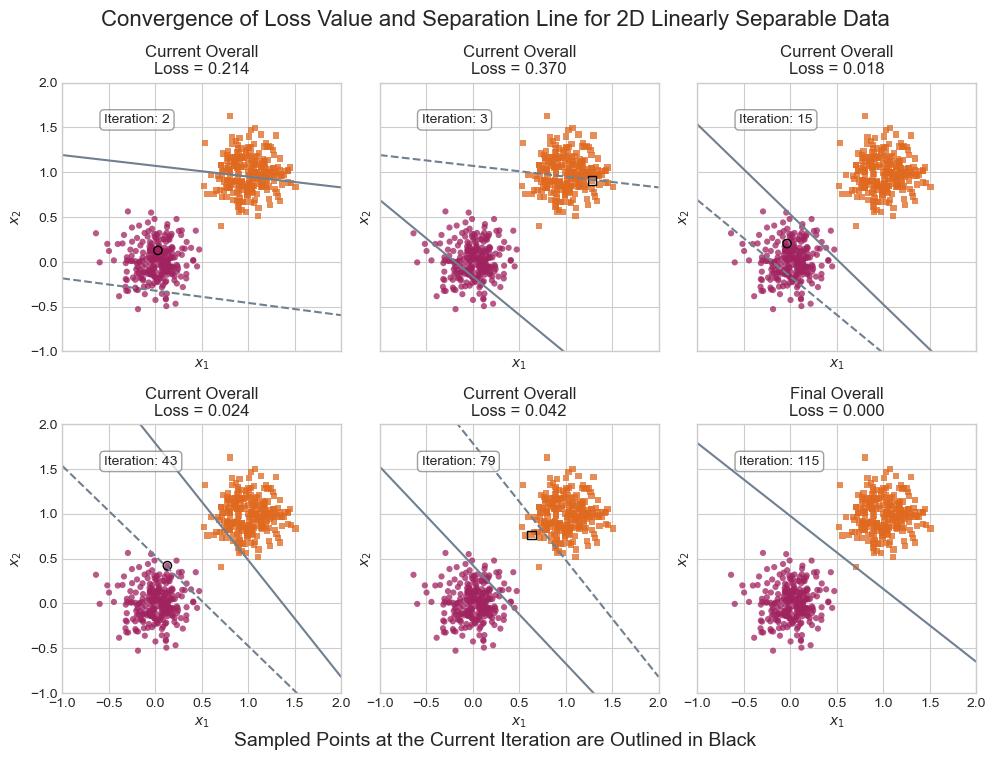

In [26]:
tch.manual_seed(100) # For consistent random sampling

# Plotting the behavior of perceptron on 2D, linearly separable data
lv1 = perceptron_plotter(X1, y1, None, 2)

*Code above re-runs the perceptron algorithm on 2D linearly separable data and plots the algorithm's progress, displaying the previous separation line, the sampled point, and the updated separation line.  The first 5 update-invoking iterations are displayed followed by the final iteration (some code provided by Prof. Chodrow).*

**Figure 2**:

The subplots above display the behavior of the perceptron algorithm on linearly separable data of two variables.  In the first five subplots, the first five update-invoking iterations of the perceptron algorithm are illustrated, highlighting the current loss value of the model, marking the randomly sampled point, and identifying both the previous separation line (i.e. the previous weights vector) and the updated separation line (i.e. the updated weight vector).  In the last subplot, the loss value of the model and the separation line of the final iteration of the algorithm is displayed.  As expected, the final loss value is $0$ and the final separation line perfectly separates the two groups of data points.

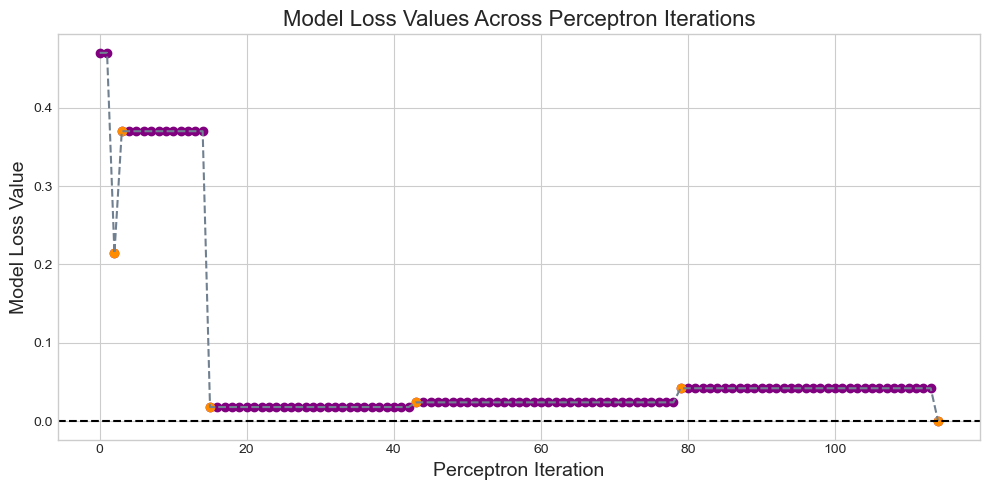

In [27]:
# Plotting the evolution of the loss values on 2D, linearly separable data
loss_plotter(lv1[0], lv1[1])

*Code above plots the changing model loss values across the iterations of the algorithm (some code provided by Prof. Chodrow).*

**Figure 3**:

The plot above portrays the evolution of the loss value over all iterations of the perceptron algorithm acting on 2D linearly separable data.  The loss values corresponding to the update-invoking iterations are marked in <span style="color:darkorange">orange</span>.  As displayed in this plot, the loss value generally decreases as the number of algorithm iterations increases.  And, supported by the last subplot in **Figure 2**, the final loss value is $0$.

### Not Linearly Separable Data

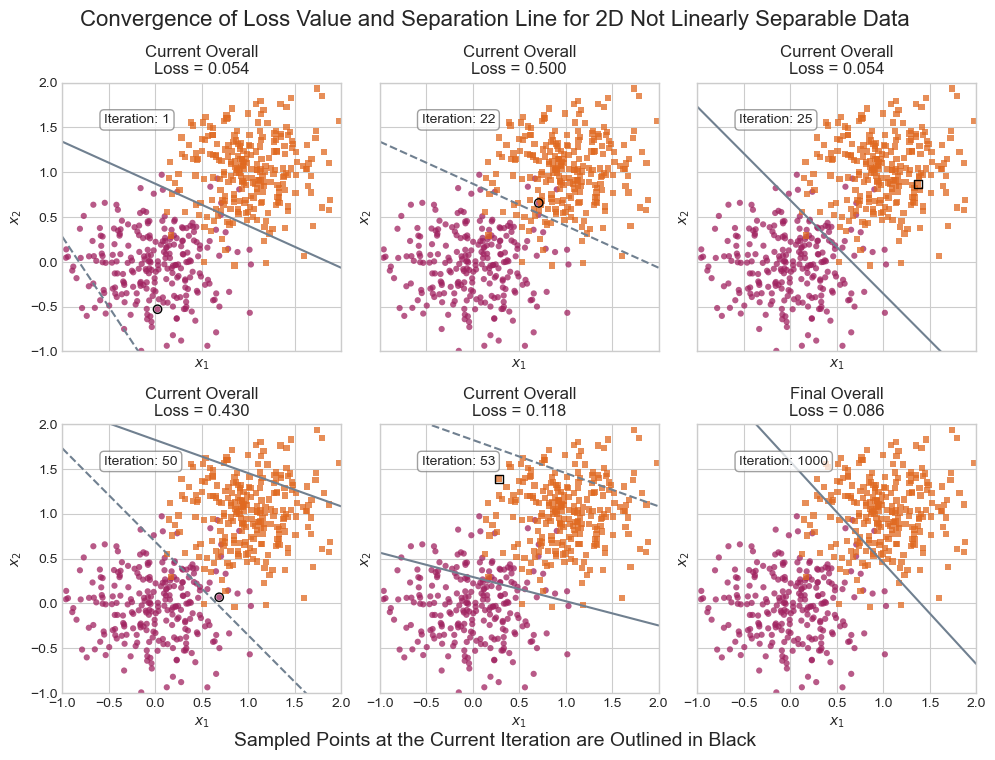

In [28]:
# Plotting perceptron behavior on 2D, not linearly separable data
lv2 = perceptron_plotter(X2, y2, 1000, 2)

*Code above mimics the plots in **Figure 2** but instead depicts the behavior of perceptron on 2D data that is not linearly separable (some code provided by Prof. Chodrow).*

**Figure 4**

The subplots above display the behavior of the perceptron algorithm on data of two variables that is **not** linearly separable.  Similarly to **Figure 2**, the first five subplots show the first five update-invoking iterations of the perceptron algorithm.   Each subplot highlights the current loss value of the model, marks the randomly sampled point, and identifies both the previous separation line (i.e. the previous weights vector) and the updated separation line (i.e. the updated weight vector).  Again, the loss value of the model and the separation line of the final iteration (the last allotted iteration in this case as controlled by the `max_it` parameter) of the algorithm is displayed in the last subplot.  As expected, the final loss value is $>0$ and the final separation line does not perfectly separate the two groups of data points.

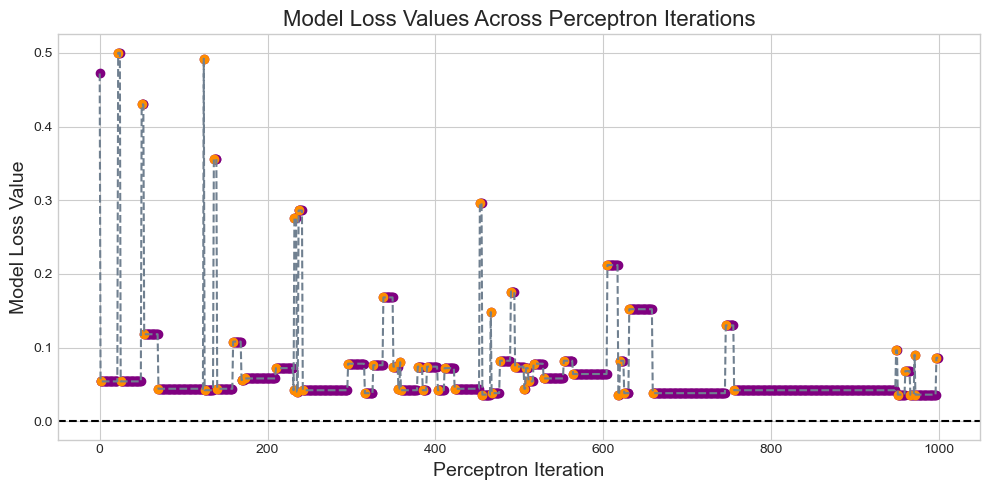

In [29]:
# Plotting the evolution of the loss value on 2D, not linearly separable data
loss_plotter(lv2[0], lv2[1])

*Code above plots the changing model loss values across the updating iterations of the algorithm (some code provided by Prof. Chodrow).*

**Figure 5**:

The plot above portrays the evolution of the loss value over all iterations of the perceptron algorithm acting on 2D not linearly separable data.  The loss values corresponding to the update-invoking iterations are marked in <span style="color:darkorange">orange</span>.  As displayed in this plot, the loss value generally decreases as the number of algorithm iterations increases.  However, within the number of allotted iterations, the loss value fails to converge to $0$.  This is supported by the last subplot in **Figure 4** showing the final loss value to be $>0$.

### Higher-Dimensional Data

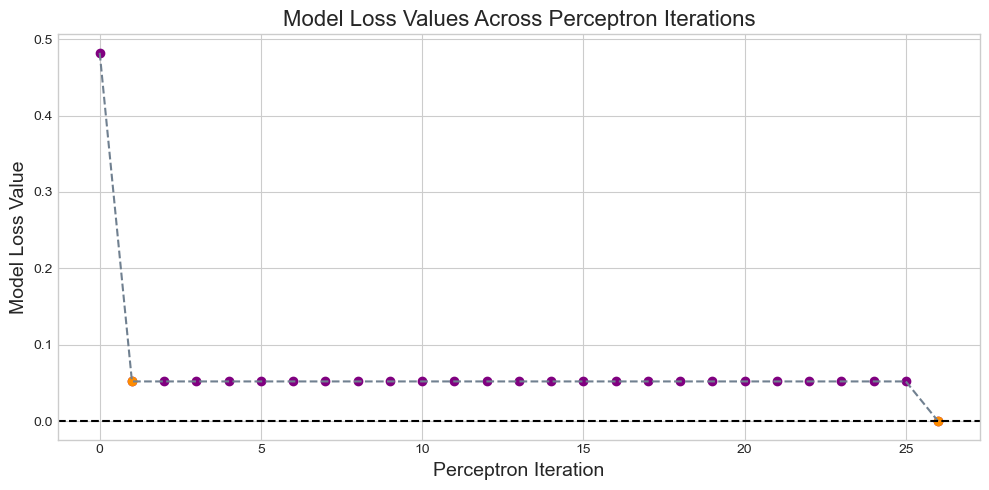

In [30]:
# Evaluating perceptron on 6D, low-noise data
lv3 = perceptron_plotter(X3, y3, None, 6)
loss_plotter(lv3[0], lv3[1])

*Code above displays the evolution of the model loss value on low-noise 6D data (some code provided by Prof. Chodrow).*

**Figure 6**

The plot above again shows the evolution in the loss function value over the iterations of the perceptron algorithm acting on low-noise data of six variables (update-invoking iterations are again marked in <span style="color:darkorange">orange</span>).  In this case, perceptron is being run on a dataset of six variables generated to have low noise.  As indicated by the rightmost point in the above plot, the perceptron algorithm seems to converge to a loss value of $0$ even when iterating over a dataset of a higher dimension.  Given this, it appears that the low-noise, 6-variable data is linearly separable.

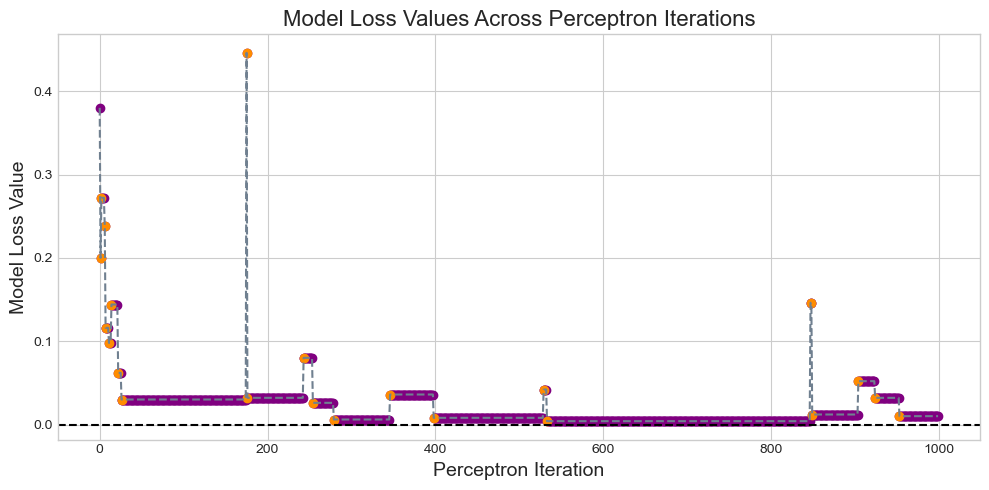

In [31]:
# Evaluating Perceptron on 6D, high-noise data
lv4 = perceptron_plotter(X4, y4, 1000, 6)
loss_plotter(lv4[0], lv4[1])

*Code above displays the evolution of the model loss value on high-noise 6D data (some code provided by Prof. Chodrow)*

**Figure 7**

The above plot now shows the evolution in the loss function value over the iterations of the perceptron algorithm $-$ run on a dataset of six variables generated to have high noise (update-invoking iterations are again marked in <span style="color:darkorange">orange</span>).  As indicated by the rightmost point in the above plot, the perceptron algorithm seems unable to converge to a loss value of $0$ within the allotted number of iterations.  Given this, it appears that the high-noise, 6-variable is not linearly separable.  Overall, it seems that the behavior of the perceptron algorithm on higher-dimensional data is analogous to that of lower-dimensional data with respect to linear separability.

## Minibatch Perceptron

An alternate version of the perceptron algorithm is the "minibatch perceptron".  During a step, minibatch perceptron computes an average update vector from a batch of randomly sampled data points rather than a single update for a single data point.  With a batch size of $k$, the minibatch perceptron update formula is the following (note that $s_{k_i}$ is the score of data point $x_{k_i}$ given by $\langle$**$w$**$, x_{k_i}\rangle$):

$$
w^{(t + 1)} = w^{(t)} + \frac{\alpha}{k}\sum_{i = 1}^{k}\mathbf{1}[s_{k_i}(2y_{k_i} - 1) < 0](2y_{k_i} - 1)x_{k_i}
$$

In [32]:
# Method to evaluate the minibatch perceptron algorithm - Some code provided by Prof. Chodrow
def MBperceptron_test(X, y, k, max_it, lr, verbose):
    
    ## Instantiate a model and an optimizer
    mbp = MBPerceptron()
    opt = MBPerceptronOptimizer(mbp)

    # Initialize the loss
    loss = 1.0

    # Bookkeeping arrays
    loss_vec = []
    updated_losses = []
    old_w_vals = []
    new_w_vals = []
    update_its = []

    while (loss > 0):
        
        # Terminating condition
        if (max_it != None) and (len(loss_vec) >= max_it):
            break

        loss = mbp.loss(X, y).item()
        loss_vec.append(loss)

        # Save the current value of w for plotting later
        curr_w = tch.clone(mbp.w)
        
        # Selecting a batch of random data points
        ix = tch.randperm(X.size(0))[:k]
        X_k = X[ix,:]
        y_k = y[ix]
        
        # Make an optimization step - Now p.w is the new weight vector
        step = opt.step(X_k, y_k, lr)
        if step > 0:
            old_w_vals.append(curr_w)
            new_w_vals.append(tch.clone(mbp.w))
            updated_loss = mbp.loss(X, y).item()
            updated_losses.append(updated_loss)
            update_its.append((len(loss_vec)))

    if (verbose):
        # Observe the algorithm's performance with the evolution of the loss function
        print(f"Evolution of loss values (with batchsize k = {k}):\n")
        for i in range(5):
            print(f"Iteration: {i} | Loss: {loss_vec[i]}")
        print("...\n")
        print(f"Total Iterations: {len(loss_vec)} | Final Loss: {loss_vec[-1]}\n")

    return [loss_vec, update_its]

In [33]:
# Evaluating perceptron on 2D, linearly separable data
mbp_eval = MBperceptron_test(X1, y1, 5, None, 0.5, True)

Evolution of loss values (with batchsize k = 5):

Iteration: 0 | Loss: 0.492000013589859
Iteration: 1 | Loss: 0.4359999895095825
Iteration: 2 | Loss: 0.3720000088214874
Iteration: 3 | Loss: 0.17599999904632568
Iteration: 4 | Loss: 0.03200000151991844
...

Total Iterations: 164 | Final Loss: 0.0



*Code above evaluates the minibatch perceptron on a given dataset, with batch size `k` and allotted iteration `max_it` adjustable (some code provided by Prof. Chodrow).*

As displayed by the output above, when operating on 2D, linearly separable data, the minibatch perceptron algorithm is able to successfully converge to a loss value of $0$.  That is, the minibatch perceptron is able to determine the exact separation line for the two groups found in the data.  Note that with a batch size of $k = 5$, the minibatch perceptron converges over $1000$ fewer iterations than the standard perceptron.

## Experimenting With Minibatch Perceptron

### With Batch Size $k = 1$

In [34]:
# Plotting the evolution of the model loss values - Code provided by Prof. Chodrow
def MBloss_plotter(ds1, ds2):
    fig, ax = plt.subplots(2, 1, figsize = (10, 7.5))
    ax[0].plot(ds1[0], color = "slategray", linestyle = "--")
    ax[0].scatter(tch.arange(len(ds1[0])), ds1[0], color = "purple")
    for i in range(len(ds1[1])):
        ax[0].scatter(ds1[1][i], ds1[0][ds1[1][i]], color = "darkorange")
    ax[0].set_ylabel("Model Loss Value", fontsize = 14)
    ax[0].set_title("Linearly Separable Data", fontsize = 16)
    ax[0].axhline(0.0, color = "black", linestyle = "--")
    ax[0].set_xlabel("M.B. Perceptron Iteration", fontsize = 14)

    if (ds2 != None):
        ax[1].plot(ds2[0], color = "gray", linestyle = "--")
        ax[1].scatter(tch.arange(len(ds2[0])), ds2[0], color = "purple")
        for i in range(len(ds2[1])):
            ax[1].scatter(ds2[1][i], ds2[0][ds2[1][i]], color = "darkorange")
        ax[1].set_xlabel("M.B. Perceptron Iteration", fontsize = 14)
        ax[1].set_ylabel("Model Loss Value", fontsize = 14)
        ax[1].set_title("Not Linearly Separable Data", fontsize = 16)
        ax[1].axhline(0.0, color = "black", linestyle = "--")
    fig.suptitle("Model Loss Values Across Minibatch Perceptron Iterations", fontsize = 18)
    plt.tight_layout()

On 2D, linearly separable data:

Evolution of loss values (with batchsize k = 1):

Iteration: 0 | Loss: 0.5
Iteration: 1 | Loss: 0.47600001096725464
Iteration: 2 | Loss: 0.47600001096725464
Iteration: 3 | Loss: 0.47600001096725464
Iteration: 4 | Loss: 0.014000000432133675
...

Total Iterations: 135 | Final Loss: 0.0

On 2D, not linearly separable data:

Evolution of loss values (with batchsize k = 1):

Iteration: 0 | Loss: 0.4740000069141388
Iteration: 1 | Loss: 0.4740000069141388
Iteration: 2 | Loss: 0.3179999887943268
Iteration: 3 | Loss: 0.15600000321865082
Iteration: 4 | Loss: 0.15600000321865082
...

Total Iterations: 1000 | Final Loss: 0.07800000160932541



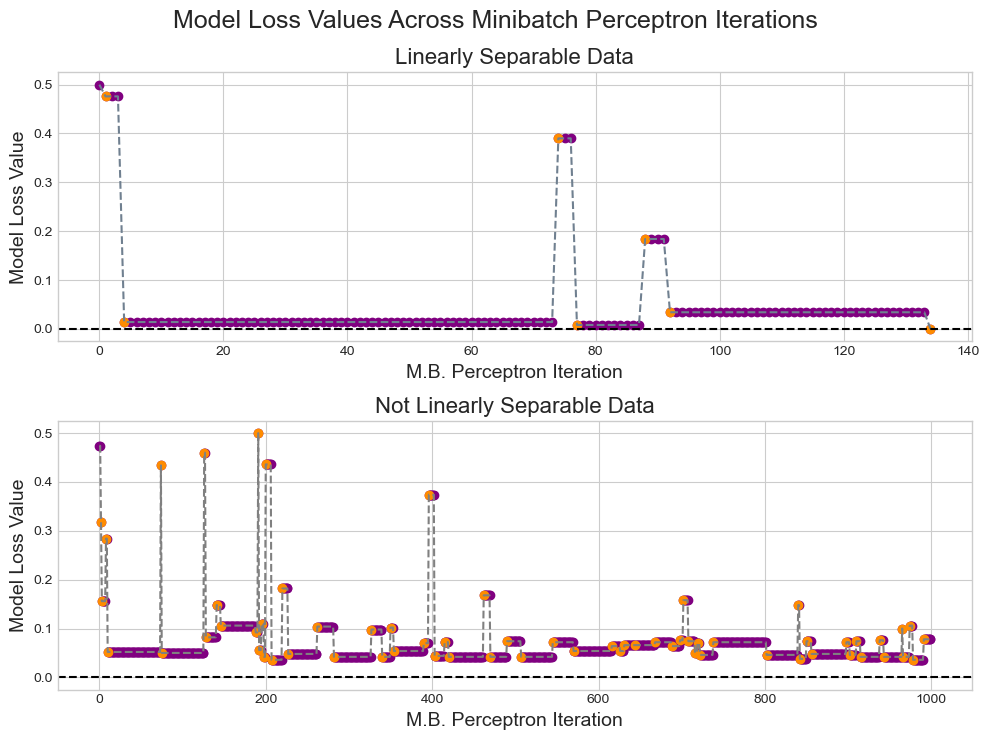

In [35]:
# Plotting the behavior of minibatch perceptron on 2D, linearly separable data -- k = 1
print("On 2D, linearly separable data:\n")
mbp_ex1 = MBperceptron_test(X1, y1, 1, None, 0.5, True)
print("On 2D, not linearly separable data:\n")
mbp_ex2 = MBperceptron_test(X2, y2, 1, 1000, 0.5, True)
MBloss_plotter(mbp_ex1, mbp_ex2)

*Code above displays the evolution of the model loss value on both linearly separable and not linearly separable 2D data using the minibatch perceptron alg. with batchsize $k = 1$ (some code provided by Prof. Chodrow)*

**Figure 8**

The figures above illustrates the evolution of the loss value of the minibatch perceptron algorithm as it iterates over both linearly separable and not linearly separable 2D data (update-invoking iterations are again marked in <span style="color:darkorange">orange</span>).  With a batch size $k = 1$, the minibatch perceptron algorithm behaves exactly like the standard perceptron algorithm.  That is, it converges to a loss value of $0$ with linearly separable data and fails to converge to a loss value of $0$ with not linearly separable data (in the number of allotted iterations).

On 6D, linearly separable data:

Evolution of loss values (with batchsize k = 1):

Iteration: 0 | Loss: 0.3959999978542328
Iteration: 1 | Loss: 0.09399999678134918
Iteration: 2 | Loss: 0.09399999678134918
Iteration: 3 | Loss: 0.09399999678134918
Iteration: 4 | Loss: 0.09399999678134918
...

Total Iterations: 27 | Final Loss: 0.0

On 6D, not linearly separable data:

Evolution of loss values (with batchsize k = 1):

Iteration: 0 | Loss: 0.27399998903274536
Iteration: 1 | Loss: 0.27399998903274536
Iteration: 2 | Loss: 0.27399998903274536
Iteration: 3 | Loss: 0.1080000028014183
Iteration: 4 | Loss: 0.1080000028014183
...

Total Iterations: 1000 | Final Loss: 0.004000000189989805



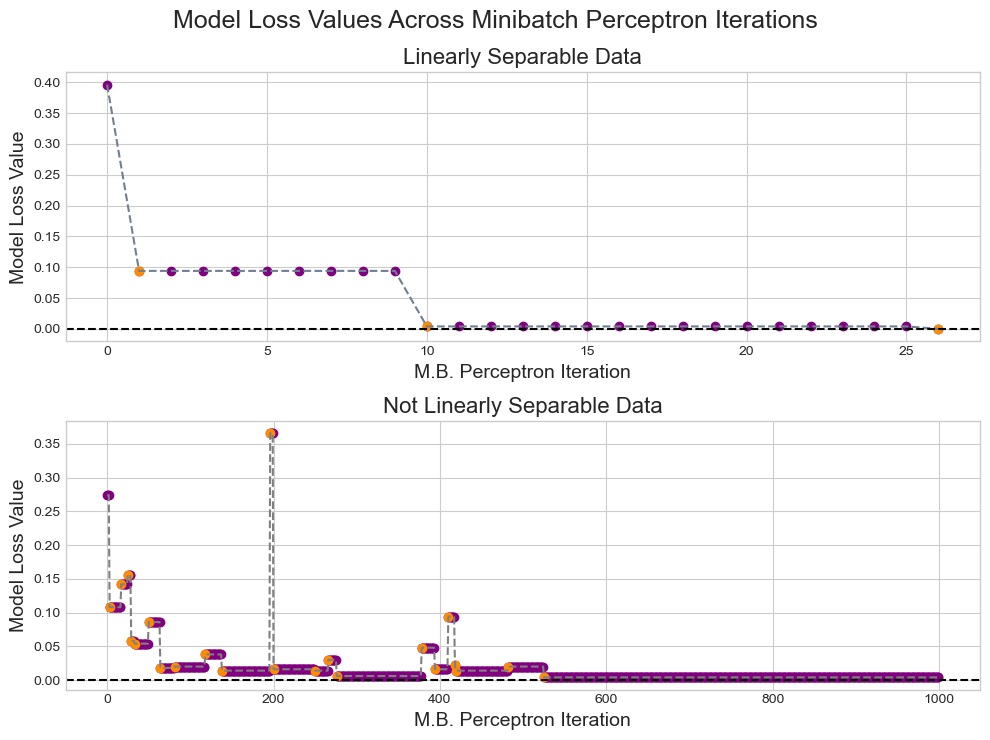

In [36]:
# Plotting the behavior of minibatch perceptron on 6D, linearly separable data -- k = 1
print("On 6D, linearly separable data:\n")
mbp_ex3 = MBperceptron_test(X3, y3, 1, None, 0.5, True)
print("On 6D, not linearly separable data:\n")
mbp_ex4 = MBperceptron_test(X4, y4, 1, 1000, 0.5, True)
MBloss_plotter(mbp_ex3, mbp_ex4)

*Code above displays the evolution of the model loss value on both linearly separable and not linearly separable 6D data using the minibatch perceptron alg. with batchsize $k = 1$ (some code provided by Prof. Chodrow)*

**Figure 9**

The figures above illustrates the evolution of the loss value of the minibatch perceptron algorithm as it iterates over both linearly separable and not linearly separable 6D data (update-invoking iterations are again marked in <span style="color:darkorange">orange</span>).  With a batch size $k = 1$, the minibatch perceptron algorithm again behaves similarly to the standard perceptron algorithm.  That is, it converges to a loss value of $0$ with linearly separable data and fails to converge to a loss value of exactly $0$ with not linearly separable data (in the number of allotted iterations).

### With Batch Size $k = 10$

In [37]:
# Plotting the evolution of the model loss values - Code provided by Prof. Chodrow - MODIFIED METHOD
def MBloss_plotter_m(ds1, ds2, nls): # nls: linear separability of the data set indicator parameter 
    filler =  " Not " if nls else " "
    fig, ax = plt.subplots(2, 1, figsize = (10, 7.5))
    ax[0].plot(ds1[0], color = "slategray", linestyle = "--")
    ax[0].scatter(tch.arange(len(ds1[0])), ds1[0], color = "purple")
    for i in range(len(ds1[1])):
        ax[0].scatter(ds1[1][i], ds1[0][ds1[1][i]], color = "darkorange")
    ax[0].set_ylabel("Model Loss Value", fontsize = 14)
    ax[0].set_title("2D Data", fontsize = 16)
    ax[0].axhline(0.0, color = "black", linestyle = "--")
    ax[0].set_xlabel("M.B. Perceptron Iteration", fontsize = 14)

    if (ds2 != None):
        ax[1].plot(ds2[0], color = "gray", linestyle = "--")
        ax[1].scatter(tch.arange(len(ds2[0])), ds2[0], color = "purple")
        for i in range(len(ds2[1])):
            ax[1].scatter(ds2[1][i], ds2[0][ds2[1][i]], color = "darkorange")
        ax[1].set_xlabel("M.B. Perceptron Iteration", fontsize = 14)
        ax[1].set_ylabel("Model Loss Value", fontsize = 14)
        ax[1].set_title("6D Data", fontsize = 16)
        ax[1].axhline(0.0, color = "black", linestyle = "--")
    fig.suptitle("Model Loss Values Across Minibatch Perceptron Iterations on" + filler + "Linearly Separable Data", fontsize = 18)
    plt.tight_layout()

On 2D, linearly separable data:

Evolution of loss values (with batchsize k = 10):

Iteration: 0 | Loss: 0.5
Iteration: 1 | Loss: 0.5
Iteration: 2 | Loss: 0.5
Iteration: 3 | Loss: 0.44200000166893005
Iteration: 4 | Loss: 0.07999999821186066
...

Total Iterations: 281 | Final Loss: 0.0

On 6D, linearly separable data:

Evolution of loss values (with batchsize k = 10):

Iteration: 0 | Loss: 0.25
Iteration: 1 | Loss: 0.2160000056028366
Iteration: 2 | Loss: 0.1860000044107437
Iteration: 3 | Loss: 0.15600000321865082
Iteration: 4 | Loss: 0.13600000739097595
...

Total Iterations: 207 | Final Loss: 0.0



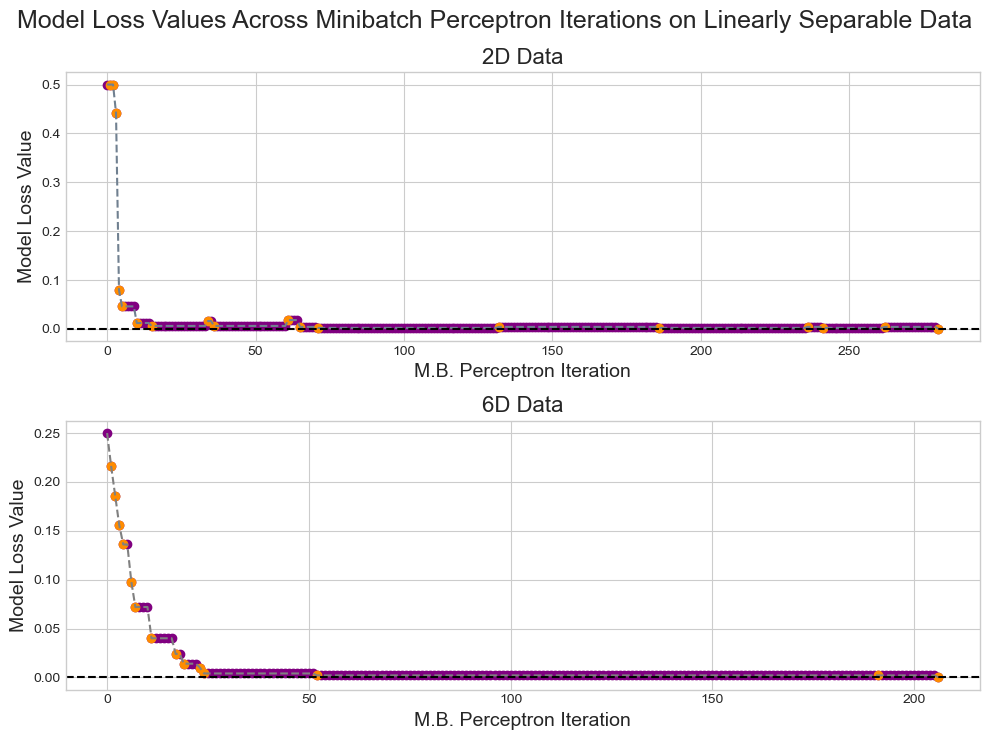

In [38]:
# Plotting the behavior of minibatch perceptron on 6D, linearly separable data -- k = 10
print("On 2D, linearly separable data:\n")
mbp_ex5 = MBperceptron_test(X1, y1, 10, None, 0.5, True)
print("On 6D, linearly separable data:\n")
mbp_ex6 = MBperceptron_test(X3, y3, 10, None, 0.5, True)
MBloss_plotter_m(mbp_ex5, mbp_ex6, False)

*Code above displays the evolution of the model loss value on linearly separable of both 2D and 6D data using the minibatch perceptron alg. with batchsize $k = 10$ (some code provided by Prof. Chodrow)*

**Figure 10**

The figures above illustrates the evolution of the loss value of the minibatch perceptron algorithm as it iterates linearly separable 2D and 6D data (update-invoking iterations are again marked in <span style="color:darkorange">orange</span>).  With a batch size $k = 10$, the minibatch perceptron algorithm is able to find the exact separation line of the data groups as indicated by the final loss value of $0$.  Interestingly, the number of iterations the minibatch perceptron takes while operating on both the linearly separable datasets is larger than that of the standard perceptron algorithm.

### With Batch Size $k = n$

On 2D, not linearly separable data:

Evolution of loss values (with batchsize k = 500):

Iteration: 0 | Loss: 0.4819999933242798
Iteration: 1 | Loss: 0.4819999933242798
Iteration: 2 | Loss: 0.4819999933242798
Iteration: 3 | Loss: 0.4819999933242798
Iteration: 4 | Loss: 0.4819999933242798
...

Total Iterations: 100000 | Final Loss: 0.03999999910593033

On 6D, not linearly separable data:

Evolution of loss values (with batchsize k = 500):

Iteration: 0 | Loss: 0.3700000047683716
Iteration: 1 | Loss: 0.3700000047683716
Iteration: 2 | Loss: 0.3700000047683716
Iteration: 3 | Loss: 0.3700000047683716
Iteration: 4 | Loss: 0.3700000047683716
...

Total Iterations: 44649 | Final Loss: 0.0



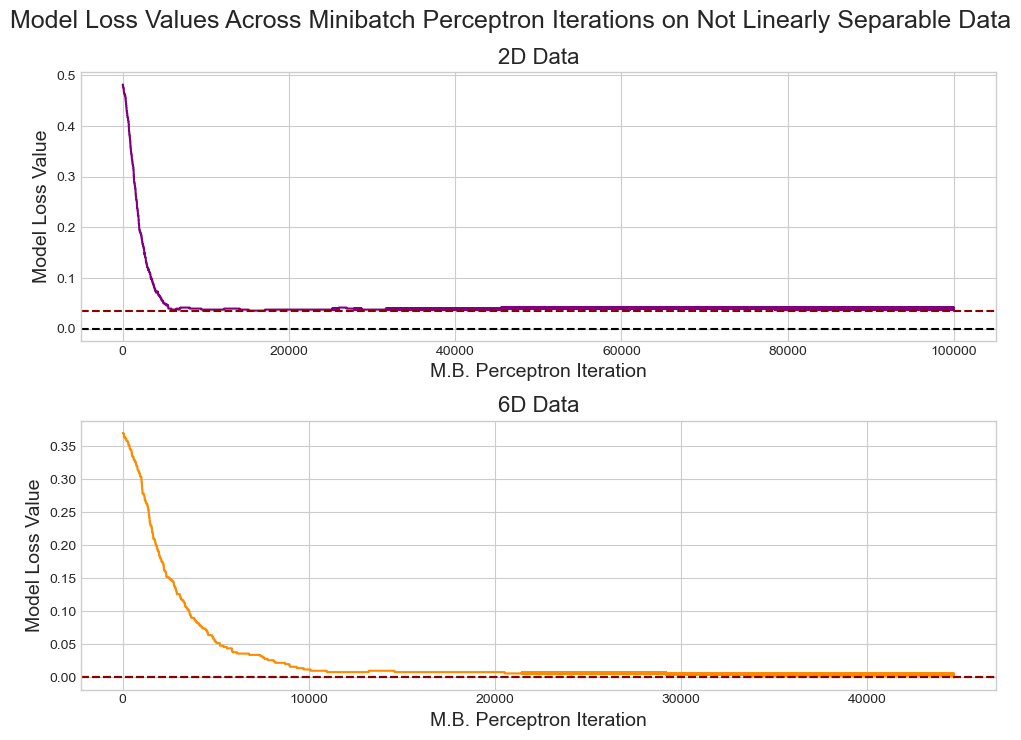

In [39]:
# Plotting the behavior of minibatch perceptron on 6D, not linearly separable data -- k = n
print("On 2D, not linearly separable data:\n")
mbp_ex7 = MBperceptron_test(X2, y2, X2.shape[0], 100000, 1e-3, True)
print("On 6D, not linearly separable data:\n")
mbp_ex8 = MBperceptron_test(X4, y4, X4.shape[0], 100000, 1e-3, True)

fig, ax = plt.subplots(2, 1, figsize = (10, 7.5))
ax[0].plot(mbp_ex7[0], color = "purple")
# ax[0].scatter(tch.arange(len(mbp_ex7[0])), mbp_ex7[0], color = "purple")
ax[0].set_ylabel("Model Loss Value", fontsize = 14)
ax[0].set_title("2D Data", fontsize = 16)
ax[0].axhline(0.0, color = "black", linestyle = "--")
ax[0].axhline(min(mbp_ex7[0]), color = "darkred", linestyle = "--")
ax[0].set_xlabel("M.B. Perceptron Iteration", fontsize = 14)

if (mbp_ex8 != None):
    ax[1].plot(mbp_ex8[0], color = "darkorange")
    # ax[1].scatter(tch.arange(len(mbp_ex8[0])), mbp_ex8[0], color = "purple")
    ax[1].set_xlabel("M.B. Perceptron Iteration", fontsize = 14)
    ax[1].set_ylabel("Model Loss Value", fontsize = 14)
    ax[1].set_title("6D Data", fontsize = 16)
    ax[1].axhline(0.0, color = "black", linestyle = "--")
    ax[1].axhline(min(mbp_ex8[0]), color = "darkred", linestyle = "--")
fig.suptitle("Model Loss Values Across Minibatch Perceptron Iterations on Not Linearly Separable Data", fontsize = 18)
plt.tight_layout()

*Code above displays the evolution of the model loss value on not linearly separable of both 2D and 6D data using the minibatch perceptron alg. with batchsize $k = n$. The <span style="color:darkred">darkred</span> dashed lines indicate the minimum loss values achieved (some code provided by Prof. Chodrow)*

**Figure 11**

The figures above illustrates the evolution of the loss value of the minibatch perceptron algorithm as it iterates over not linearly separable 2D and 6D data.  The purpose of this experiment is to observe whether or not this algorithm will converge on data that is not linearly separable given a small enough learning rate $\alpha$.  In this case, the learning rate is set to $\alpha = 0.001$.  With a batch size $k = n$, the minibatch perceptron algorithm does appear to converge (note that $100000$ iterations were allotted).  For the 2D data, the algorithm is unable to achieve a loss value of $0$, but visually converges to a loss value of approximately $0.36$.  Interestingly, on the 6D data, the algorithm also converges and does seem to achieve a loss value of $0$.  In general, it appears that the minibatch perceptron is still able to converge to some decreased loss value even when operating on data that is not linearly separable (that's cool!).

## Runtime Analysis

**Standard Perceptron Algorithm**:

During a given step of the standard perceptron algorithm, two primary computations occur.  First, the current loss value of the linear model is calculated.  The loss calculation involves computing the score of each data point in the feature matrix $\mathbf{X}$, multiplying each score $s_i$ by the corresponding modified target $y_i'$, and checking if $s_iy_i' > 0$.  Then, the average of all values $s_iy_i' > 0$ is taken.  Note that the loss calculation has a complexity of $O(p)$ as there are $p$ elements (features) in each row of $\mathbf{X}$.  The second computation of a step involves subtracting the current gradient of the loss function from the current weights vector.  Similarly, computing the gradient has a complexity of $O(p)$.  Overall, the complexity of a step of the standard perceptron algorithm is $O(p)$ where $p$ is the number of features in a given row of the feature matrix $\mathbf{X}$.

**Minibatch Perceptron Algorithm**:

In general, the processes of a given step of the minibatch perceptron algorithm are identical to those of the standard algorithm, only they are computed using a random submatrix (size $k$ x $p$) of $\mathbf{X}$ instead of a single row.  Given this, the minibatch perceptron performs essentially the same computations as the standard algorithm but $k$ times.  Therefore, the complexity of a given step of the minibatch perceptron algorithm is $O(kp)$ where $k$ is the number of rows in the sampled submatrix of $\mathbf{X}$ and $p$ is the number of features in a given row of $\mathbf{X}$.

# Conclusion

The general purpose of this study was to investigate and explore a famous, widely recognized, and foundational machine learning algorithm: Perceptron.  To dive into this cornerstone procedure of ML, I implemented two basic versions of this algorithm.  

My initial implementation is a representation of the standard perceptron.  With this algorithm, I examined how it behaved on data sets of different variables and linear separability.  As expected, I found that the standard algorithm performed well (usually perfectly) when tasked with classifying linearly separable data, regardless of the data's dimensional complexity.  Additionally as expected, I found that the standard algorithm struggled to achieve perfect accuracy on data that is not linearly separable, again regardless of the data's dimensional complexity.

The other implementation represents an alternative version of the perceptron algorithm known as the "minibatch perceptron".  This alternative algorithm is similar to the standard version, but differs in its computation of an "update".  The minibatch perceptron takes in a batch of random data points to update by, instead of a single random data point like the standard algorithm.  With a batch size of $1$, I found the minibatch perceptron to perform exactly like the standard perceptron.  As I increased the batch size, I observed that the minibatch algorithm was still able to achieve a loss value of $0$ and identify the exact separation line for linearly separable data.  Interestingly, when setting the batch size equal to the total number of data points, I found that this alternative version of the algorithm was able to converge to a loss value equal to or smaller than that of the standard algorithm even when operating on data that is not linearly separable.

Overall, this study gave me the opportunity to dive into several key processes of ML under the hood and gain some initial experience with gradient-based optimization methods.

*During the implementation process of this replication study, I collaborated with Omar Armbruster.  For more information and documentation on my algorithm implementations, visit [perceptron.py](https://github.com/Col-McDermott/Col-McDermott.github.io/blob/main/posts/post_4/perceptron.py) and [MBperceptron.py](https://github.com/Col-McDermott/Col-McDermott.github.io/blob/main/posts/post_4/MBperceptron.py).*